In [9]:
# Code imports
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [121]:
# Set the batch size and image size for faster training
batch_size = 64
image_size = 128

# Load the testing training dataset with shuffling and resizing
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/dermnet/test",
   shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/dermnet/train",
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)


Found 4002 files belonging to 23 classes.
Found 15557 files belonging to 23 classes.


In [122]:
# Get the class names from the training dataset
class_names = train_dataset.class_names

# Print the class names
print("Class Names:", class_names)

Class Names: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


In [123]:
# Get the length of the training dataset
num_train_samples = len(train_dataset)

# Print the number of samples in the training dataset
print("Number of samples in the training dataset:", num_train_samples)

Number of samples in the training dataset: 244


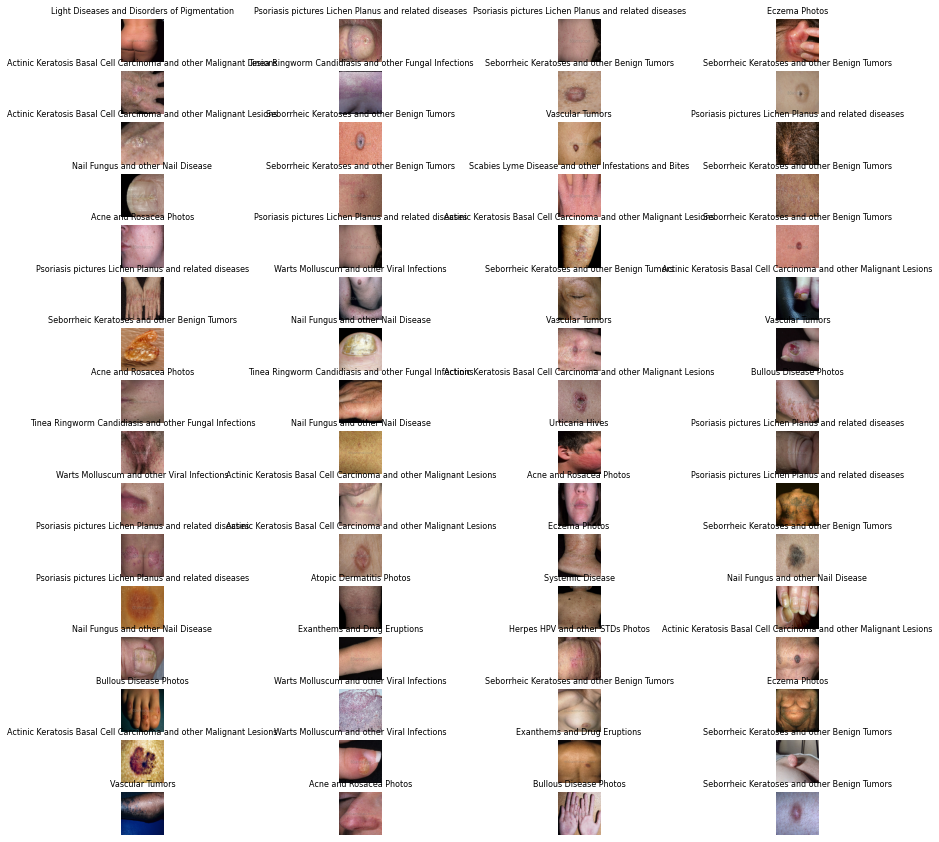

In [124]:
fig_size = 15
# Set the figure size
plt.figure(figsize=(fig_size, fig_size))

# Iterate over the first batch of images and labels in the train_dataset
for image_batch, label_batch in train_dataset.take(1):
    # Iterate over each image in the batch
    for i in range(batch_size):
        # Create a subplot
        ax = plt.subplot(16, 4, i + 1)
        
        # Display the image
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        # Set the title of the subplot to the corresponding label
        plt.title(class_names[label_batch[i]], fontsize=8)
        
        # Turn off the axis labels
        plt.axis("off")

# Show the plot
plt.show()

In [125]:
def get_dataset_partitions(dataset, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    # Ensure that the train and validation split ratios add up to 1
    assert (train_split + val_split) == 1.0, "Train and validation split ratios should add up to 1."
    
    dataset_size = len(dataset)
    
    # Shuffle the dataset if specified
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    # Calculate the sizes of training and validation partitions
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    # Create the training dataset by taking the first train_size elements
    train_ds = dataset.take(train_size)
    
    # Create the validation dataset by skipping the training elements and taking the next val_size elements
    val_ds = dataset.skip(train_size).take(val_size)
    
    # Return the training and validation dataset partitions
    return train_ds, val_ds

In [126]:
# Partition the train_dataset into training and validation datasets
train_ds, val_ds = get_dataset_partitions(train_dataset)

# The train_dataset is partitioned into training and validation datasets using the get_dataset_partitions function.
# This ensures that the data is split into separate sets for training the model and evaluating its performance.
# The training dataset is stored in the train_ds variable, while the validation dataset is stored in the val_ds variable.
# This separation allows for accurate assessment of the model's performance during training, helping to achieve high accuracy.
# By training on the training dataset and evaluating on the validation dataset, the model can learn and generalize effectively.

In [127]:
# Cache, shuffle, and prefetch the training dataset
shuffle_count = 1000
train_dataset = train_dataset.cache().shuffle(shuffle_count).prefetch(buffer_size=tf.data.AUTOTUNE)

# Cache, shuffle, and prefetch the validation dataset
val_dataset = val_ds.cache().shuffle(shuffle_count).prefetch(buffer_size=tf.data.AUTOTUNE)

# Cache, shuffle, and prefetch the test dataset
test_ds = test_dataset.cache().shuffle(shuffle_count).prefetch(buffer_size=tf.data.AUTOTUNE)

# The training, validation, and test datasets are optimized for fast and accurate model training and evaluation.
# The operations applied to each dataset are as follows:
# - cache(): Caches the dataset in memory, avoiding repeated disk reads and speeding up data access.
# - shuffle(shuffle_count): Shuffles the dataset using a buffer size of 1000, introducing randomness and preventing overfitting.
# - prefetch(buffer_size=tf.data.AUTOTUNE): Overlaps data preprocessing and model execution, maximizing training efficiency.
# These operations ensure that the datasets are efficiently loaded, shuffled, and readily available for the model during training and evaluation.
# By caching, shuffling, and prefetching the datasets, we optimize the data pipeline, leading to faster execution and improved accuracy.

In [128]:
# Create a sequential model for resizing and rescaling images
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [129]:
# Create a sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor=0.2),
])

In [130]:
def apply_data_augmentation(image, training):
    """
    Apply data augmentation to the input image.
    
    Args:
        image: Input image tensor.
        training: Boolean flag indicating if data augmentation should be applied (True during training, False during testing).
    
    Returns:
        Augmented image tensor.
    """
    if training:
        # Apply random flips (horizontal and vertical) to the image
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        
        # Apply random rotations to the image
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Normalize the pixel values of the image to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    
    return image


# Apply data augmentation to the training dataset
train_ds = train_ds.map(
    lambda x, y: (apply_data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# The train_ds dataset is mapped using the map() function to apply data augmentation to each image in the dataset.
# The lambda function takes an input image 'x' and its corresponding label 'y', and applies the apply_data_augmentation() function to the image.
# The apply_data_augmentation() function applies random flips (horizontal and vertical) and rotations to the image to augment the data and increase its diversity.
# The resulting augmented image and its original label are returned as a tuple.
# This mapping operation is performed on the training dataset to enhance the training data with augmented samples.

# The prefetch() function is then used to prefetch and buffer the augmented dataset to optimize performance.
# The buffer_size argument is set to tf.data.AUTOTUNE to automatically determine the optimal buffer size based on available system resources.
# Prefetching allows for overlapping of data preprocessing and model execution, improving training efficiency.


In [183]:
# Define the model architecture for image classification

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu', input_shape=(image_size, image_size, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='softmax')
])
model.build(input_shape=(batch_size, image_size, image_size, 3))


In [184]:
# Print the summary of the model
model.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_28 (Sequential)   (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_208 (Conv2D)          (64, 127, 127, 64)        832       
_________________________________________________________________
max_pooling2d_208 (MaxPoolin (64, 63, 63, 64)          0         
_________________________________________________________________
conv2d_209 (Conv2D)          (64, 61, 61, 64)          36928     
_________________________________________________________________
max_pooling2d_209 (MaxPoolin (64, 30, 30, 64)          0         
_________________________________________________________________
conv2d_210 (Conv2D)          (64, 28, 28, 64)          36928     
_________________________________________________________________
max_pooling2d_210 (MaxPoolin (64, 14, 14, 64)        

In [188]:
# Compile the model with appropriate optimizer, loss function, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # Use Adam optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Categorical cross-entropy loss
    metrics=['accuracy']  # Track accuracy metric
)


In [186]:
num_epochs = 100  # Number of training epochs

# Train the model
history = model.fit(
    train_dataset,  # Training dataset
    epochs=num_epochs,  # Number of epochs
    batch_size=batch_size,  # Batch size for training
    validation_data=val_dataset,  # Validation dataset
    verbose=1,  # Verbosity mode: 1 for progress updates, 0 for silent
)

Epoch 1/100
244/244 [==============================] - 235s 959ms/step - loss: 3.0865 - accuracy: 0.0872 - val_loss: 2.9772 - val_accuracy: 0.0863
Epoch 2/100
244/244 [==============================] - 232s 949ms/step - loss: 2.9293 - accuracy: 0.1265 - val_loss: 2.8139 - val_accuracy: 0.1520
Epoch 3/100
244/244 [==============================] - 233s 954ms/step - loss: 2.8218 - accuracy: 0.1635 - val_loss: 2.7507 - val_accuracy: 0.1872
Epoch 4/100
244/244 [==============================] - 233s 956ms/step - loss: 2.7513 - accuracy: 0.1827 - val_loss: 2.6673 - val_accuracy: 0.2078
Epoch 5/100
244/244 [==============================] - 230s 944ms/step - loss: 2.6777 - accuracy: 0.2072 - val_loss: 2.5684 - val_accuracy: 0.2436
Epoch 6/100
244/244 [==============================] - 230s 944ms/step - loss: 2.6126 - accuracy: 0.2231 - val_loss: 2.5109 - val_accuracy: 0.2599
Epoch 7/100
244/244 [==============================] - 232s 950ms/step - loss: 2.5626 - accuracy: 0.2418 - val_loss: 2

In [189]:
# Retrieve accuracy values from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve loss values from training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

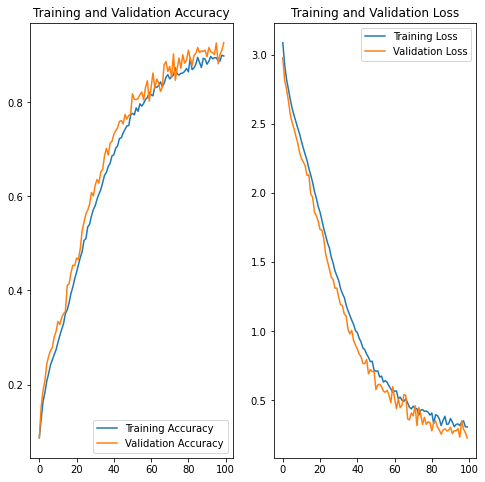

In [196]:
# Set the figure size
fig_size2 = 8
plt.figure(figsize=(fig_size2, fig_size2))

# Plot the training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots
plt.show()

First image to predict
Actual label: Light Diseases and Disorders of Pigmentation
Predicted label: Tinea Ringworm Candidiasis and other Fungal Infections


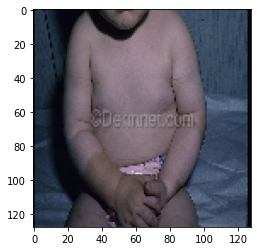

In [202]:
# Iterate over the first batch of images and labels in the test dataset
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[63].numpy().astype('uint8')
    first_label = labels_batch[63].numpy()
    
    # Display the first image and its actual label
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])
    
    # Perform batch prediction on the images
    batch_prediction = model.predict(images_batch)
    
   
    predicted_label = np.argmax(batch_prediction[63])
    
    # Display the predicted label
    print("Predicted label:", class_names[predicted_label])

In [203]:
def predict(model, img):
    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    
    # Expand the dimensions to match the expected input shape of the model
    img_array = tf.expand_dims(img_array, 0)

    # Perform prediction on the image using the model
    predictions = model.predict(img_array)

    # Get the predicted class label and confidence
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

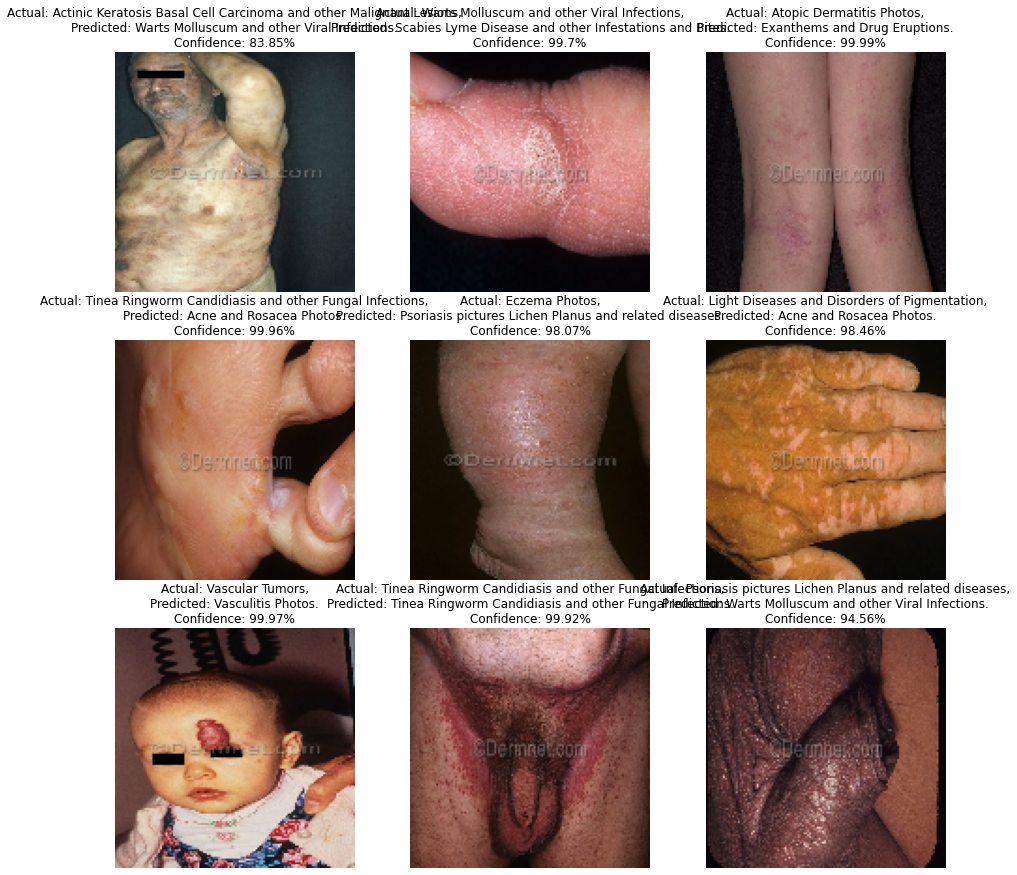

In [205]:
plt.figure(figsize=(fig_size, fig_size))

# Iterate over the test dataset and display a grid of images with predictions
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the image
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Make predictions for the current image
        predicted_class, confidence = predict(model, images[i])
        
        # Get the actual class label
        actual_class = class_names[labels[i]]
        
        # Set the title of the subplot with actual and predicted class labels, and confidence score
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        
        # Remove axis ticks
        plt.axis("off")

In [206]:
# Save the trained model
model.save("./model/build")

# This code saves the trained model for future use.

# The model.save() function is used to save the model to the specified directory.
# The directory path "./model/build" indicates the location where the model will be saved.
# Make sure to provide a suitable directory path based on your system configuration and requirements.

# Saving the model allows you to reuse it later without having to retrain it from scratch.
# It captures the model's architecture, weights, and optimizer state, allowing you to restore the trained model at a later time.
# This is particularly useful when you want to deploy the model for production use or continue training it in the future.
# The saved model can be loaded using tf.keras.models.load_model() function.